In [1]:
import sys
sys.path.append('../scripts')
sys.path.append('../src')

from data_prep import load_stock_data
from sentiment_analysis import analyze_sentiment
from correlation_analysis import calculate_stock_returns, align_sentiment_with_returns, calculate_correlations
import pandas as pd
import os

In [2]:
os.chdir('..')  # Change to project root

# Load stock data
files = ["AAPL.csv", "GOOG.csv", "MSFT.csv", "AMZN.csv", "NVDA.csv", "META.csv"]
stocks = load_stock_data(files)

print("Stocks loaded:")
for symbol, df in stocks.items():
    print(f"{symbol}: {df.shape}")

Stocks loaded:
AAPL: (3774, 6)
GOOG: (3774, 6)
MSFT: (3774, 6)
AMZN: (3774, 6)
NVDA: (3774, 6)
META: (2923, 6)


In [11]:

print("Performing sentiment analysis on news headlines...")
news_df = analyze_sentiment(news_df)

print("Sentiment analysis completed!")
print("New columns added:", [col for col in news_df.columns if 'sentiment' in col])

print("\nSentiment score statistics:")
print("VADER Sentiment:")
print(news_df['vader_sentiment'].describe())
print("\nTextBlob Sentiment:")
print(news_df['textblob_sentiment'].describe())

Performing sentiment analysis on news headlines...
Sentiment analysis completed!
New columns added: ['textblob_sentiment', 'vader_sentiment']

Sentiment score statistics:
VADER Sentiment:
count    1.407328e+06
mean     6.690980e-02
std      2.722861e-01
min     -9.578000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      2.023000e-01
max      9.741000e-01
Name: vader_sentiment, dtype: float64

TextBlob Sentiment:
count    1.407328e+06
mean     4.905657e-02
std      1.830652e-01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: textblob_sentiment, dtype: float64


In [14]:

print("Sample headlines with sentiment scores:")
sample_news = news_df[['headline', 'vader_sentiment', 'textblob_sentiment']].head(10)
for idx, row in sample_news.iterrows():
    print(f"\nHeadline: {row['headline'][:80]}...")
    print(f"VADER: {row['vader_sentiment']:.3f}, TextBlob: {row['textblob_sentiment']:.3f}")

Sample headlines with sentiment scores:

Headline: Stocks That Hit 52-Week Highs On Friday...
VADER: 0.000, TextBlob: 0.000

Headline: Stocks That Hit 52-Week Highs On Wednesday...
VADER: 0.000, TextBlob: 0.000

Headline: 71 Biggest Movers From Friday...
VADER: 0.000, TextBlob: 0.000

Headline: 46 Stocks Moving In Friday's Mid-Day Session...
VADER: 0.000, TextBlob: 0.000

Headline: B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target...
VADER: 0.296, TextBlob: 0.000

Headline: CFRA Maintains Hold on Agilent Technologies, Lowers Price Target to $85...
VADER: -0.128, TextBlob: 0.000

Headline: UBS Maintains Neutral on Agilent Technologies, Raises Price Target to $87...
VADER: 0.000, TextBlob: 0.000

Headline: Agilent Technologies shares are trading higher after the company reported better...
VADER: 0.296, TextBlob: 0.250

Headline: Wells Fargo Maintains Overweight on Agilent Technologies, Raises Price Target to...
VADER: -0.128, TextBlob: 0.000

Headline: 10 B

In [17]:
print("Cleaning news dates...")

# Handle the inconsistent date formats
def parse_news_date(date_str):
    try:
        # Try parsing with timezone info first
        return pd.to_datetime(date_str, utc=True).date()
    except:
        try:
            # Try without timezone info
            return pd.to_datetime(date_str).date()
        except:
            return None

# Apply the date parsing
news_df['date_clean'] = news_df['date'].apply(parse_news_date)

# Remove rows with invalid dates
original_count = len(news_df)
news_df = news_df.dropna(subset=['date_clean'])
print(f"Removed {original_count - len(news_df)} rows with invalid dates")

print("Date cleaning completed!")
print(f"News date range: {news_df['date_clean'].min()} to {news_df['date_clean'].max()}")
print(f"Total news articles after cleaning: {len(news_df)}")

Cleaning news dates...
Removed 0 rows with invalid dates
Date cleaning completed!
News date range: 2009-02-14 to 2020-06-11
Total news articles after cleaning: 1407328


In [18]:

print("Calculating correlations between news sentiment and stock returns...")

correlation_results = {}

for symbol in stocks.keys():
    print(f"\nAnalyzing {symbol}...")
    
    # Align sentiment with stock returns
    merged_data = align_sentiment_with_returns(news_df, stocks[symbol], symbol)
    
    if len(merged_data) > 10:  # Need enough data points for meaningful correlation
        correlations = calculate_correlations(merged_data)
        correlation_results[symbol] = correlations
        
        print(f"  Data points: {len(merged_data)}")
        for method, result in correlations.items():
            print(f"  {method.upper()}: r={result['correlation']:.4f}, p={result['p_value']:.4f}")
    else:
        print(f"  Not enough data (only {len(merged_data)} points)")

Calculating correlations between news sentiment and stock returns...

Analyzing AAPL...
  Data points: 61
  VADER: r=0.1239, p=0.3413
  TEXTBLOB: r=0.1581, p=0.2235

Analyzing GOOG...
  Data points: 352
  VADER: r=0.1895, p=0.0003
  TEXTBLOB: r=0.0568, p=0.2877

Analyzing MSFT...
  Not enough data (only 0 points)

Analyzing AMZN...
  Data points: 28
  VADER: r=0.1668, p=0.3963
  TEXTBLOB: r=-0.0297, p=0.8805

Analyzing NVDA...
  Data points: 1125
  VADER: r=0.2148, p=0.0000
  TEXTBLOB: r=0.1035, p=0.0005

Analyzing META...
  Not enough data (only 0 points)


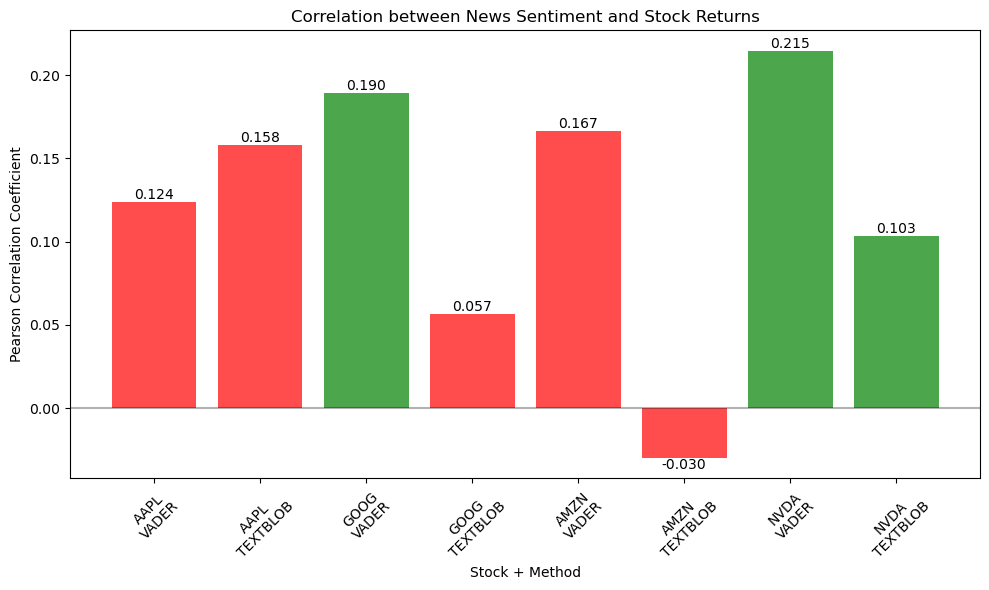


Significant correlations (p < 0.05):
  Stock    Method  Correlation       P_Value
2  GOOG     VADER     0.189528  3.493346e-04
6  NVDA     VADER     0.214769  3.321368e-13
7  NVDA  TEXTBLOB     0.103473  5.087986e-04


In [19]:

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization
corr_data = []
for symbol, results in correlation_results.items():
    for method, values in results.items():
        corr_data.append({
            'Stock': symbol,
            'Method': method.upper(),
            'Correlation': values['correlation'],
            'P_Value': values['p_value'],
            'Significant': values['p_value'] < 0.05
        })

corr_df = pd.DataFrame(corr_data)

# Create visualization
plt.figure(figsize=(10, 6))
colors = ['red' if not sig else 'green' for sig in corr_df['Significant']]
bars = plt.bar(range(len(corr_df)), corr_df['Correlation'], color=colors, alpha=0.7)

plt.title('Correlation between News Sentiment and Stock Returns')
plt.xlabel('Stock + Method')
plt.ylabel('Pearson Correlation Coefficient')
plt.xticks(range(len(corr_df)), [f"{row['Stock']}\n{row['Method']}" for _, row in corr_df.iterrows()], rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

print("\nSignificant correlations (p < 0.05):")
significant = corr_df[corr_df['Significant'] == True]
print(significant[['Stock', 'Method', 'Correlation', 'P_Value']])

Creating scatter plots for all stocks...


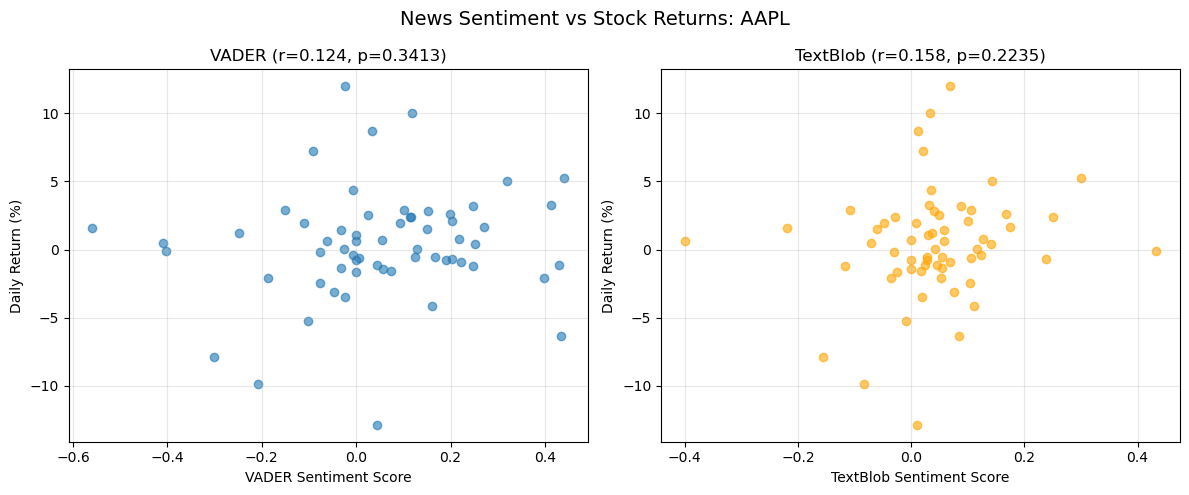

AAPL - Data points: 61
  Date range: 2020-03-09 to 2020-06-10


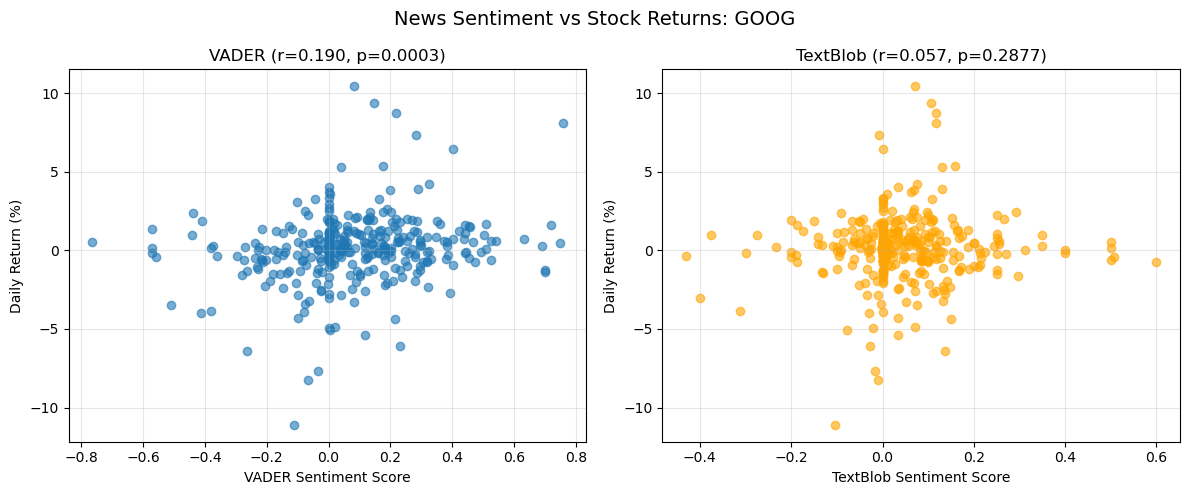

GOOG - Data points: 352
  Date range: 2018-11-13 to 2020-06-10


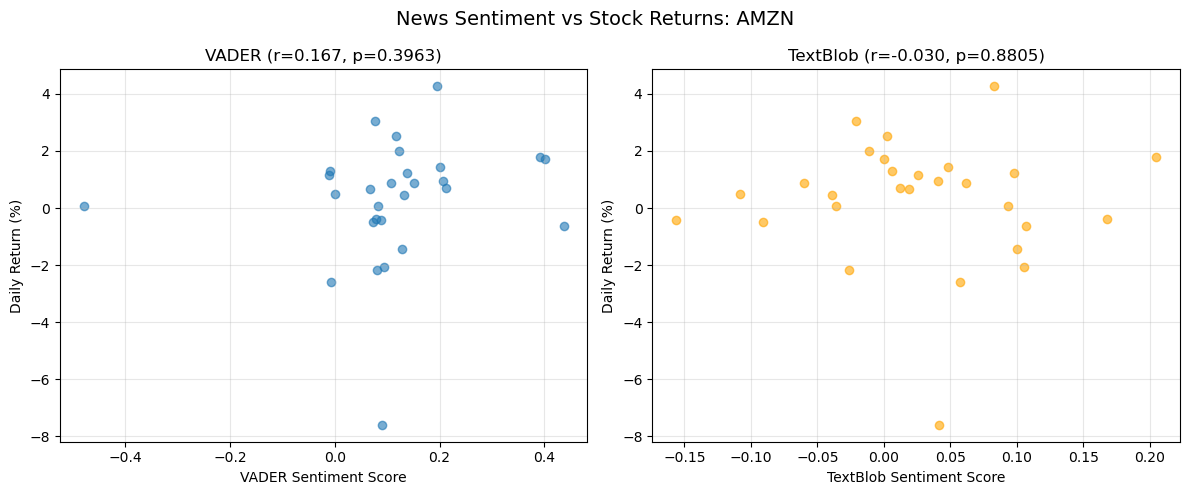

AMZN - Data points: 28
  Date range: 2020-04-27 to 2020-06-10


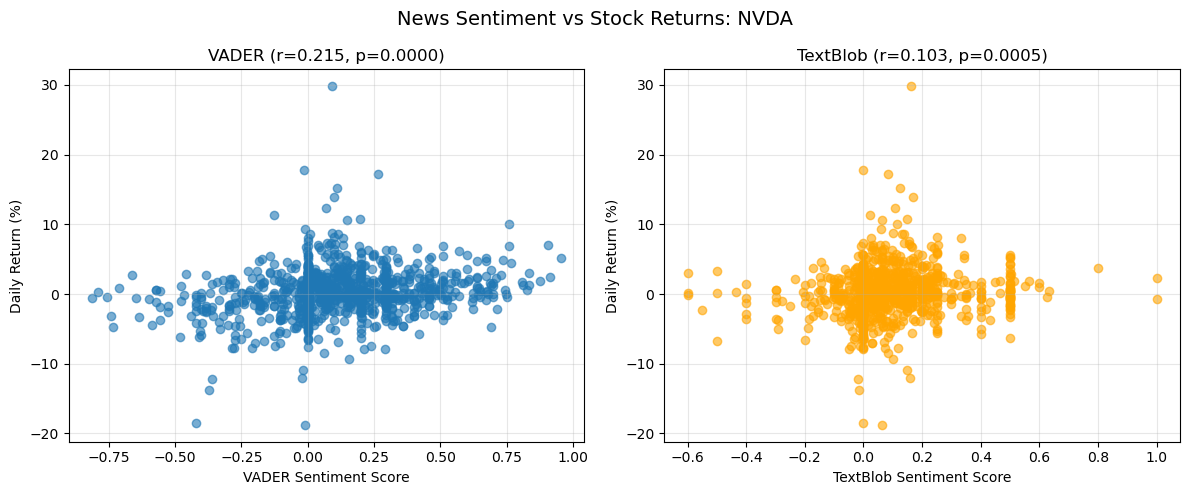

NVDA - Data points: 1125
  Date range: 2011-03-03 to 2020-06-10


In [22]:

print("Creating scatter plots for all stocks...")

for symbol in stocks.keys():
    if symbol in correlation_results and len(correlation_results[symbol]) > 0:
        # Get the merged data for this stock
        merged_data = align_sentiment_with_returns(news_df, stocks[symbol], symbol)
        
        if len(merged_data) > 5:  # Even if just a few data points
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            fig.suptitle(f'News Sentiment vs Stock Returns: {symbol}', fontsize=14)
            
            # VADER scatter plot
            vader_corr = correlation_results[symbol]["vader"]["correlation"]
            vader_pval = correlation_results[symbol]["vader"]["p_value"]
            ax1.scatter(merged_data['vader_sentiment'], merged_data['daily_return'], alpha=0.6)
            ax1.set_xlabel('VADER Sentiment Score')
            ax1.set_ylabel('Daily Return (%)')
            ax1.set_title(f'VADER (r={vader_corr:.3f}, p={vader_pval:.4f})')
            ax1.grid(True, alpha=0.3)
            
            # TextBlob scatter plot
            textblob_corr = correlation_results[symbol]["textblob"]["correlation"]
            textblob_pval = correlation_results[symbol]["textblob"]["p_value"]
            ax2.scatter(merged_data['textblob_sentiment'], merged_data['daily_return'], alpha=0.6, color='orange')
            ax2.set_xlabel('TextBlob Sentiment Score')
            ax2.set_ylabel('Daily Return (%)')
            ax2.set_title(f'TextBlob (r={textblob_corr:.3f}, p={textblob_pval:.4f})')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"{symbol} - Data points: {len(merged_data)}")
            print(f"  Date range: {merged_data['date_only'].min()} to {merged_data['date_only'].max()}")

Creating time series visualizations for all stocks...


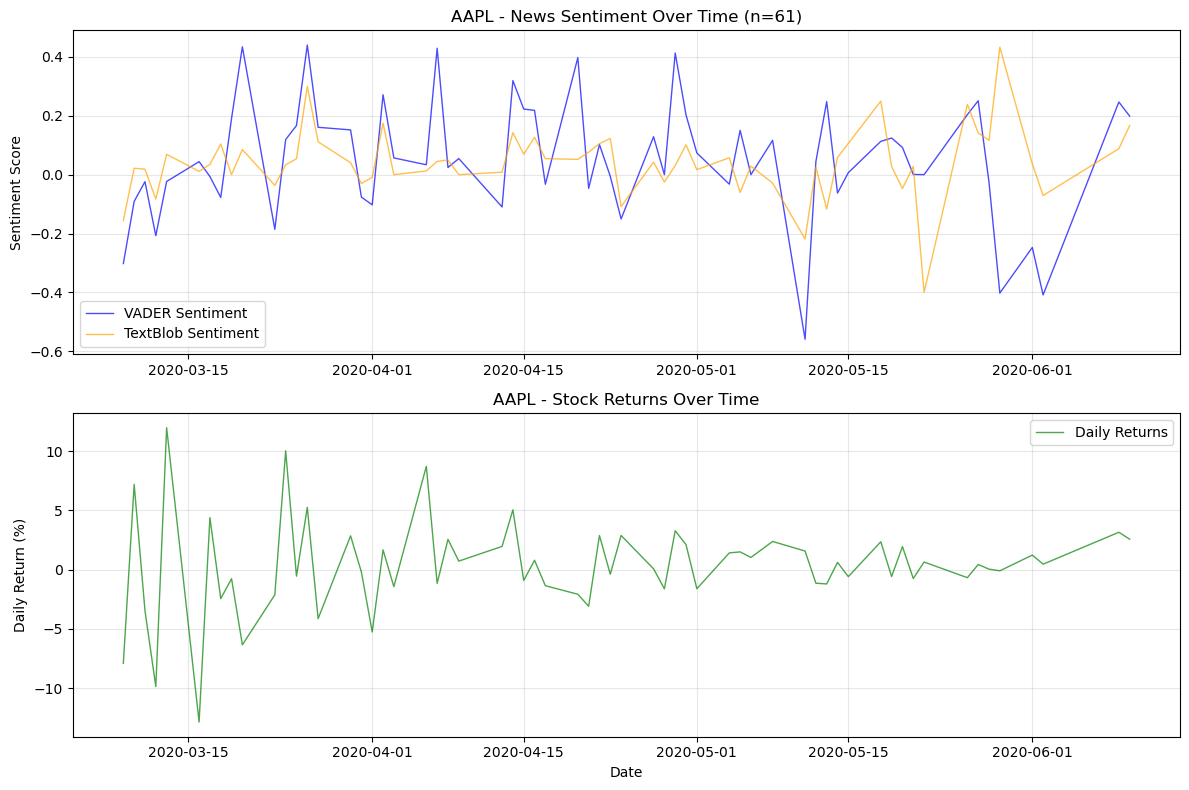

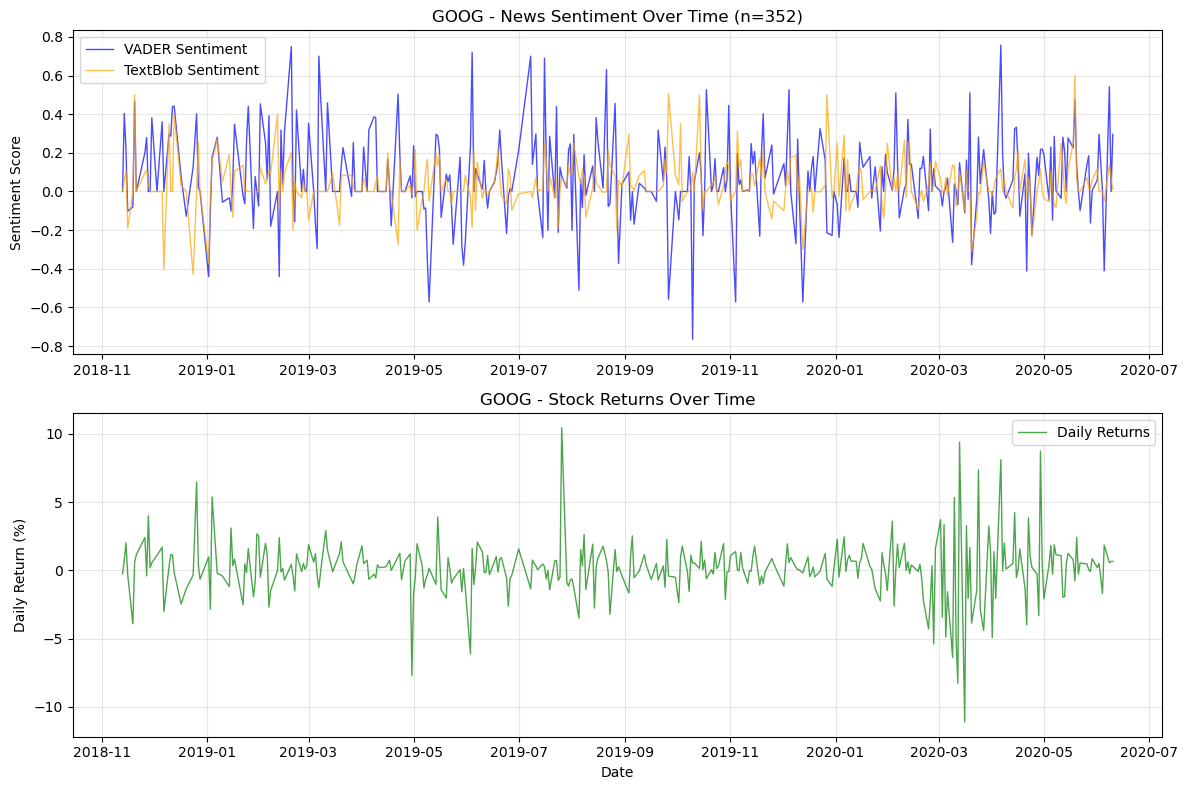

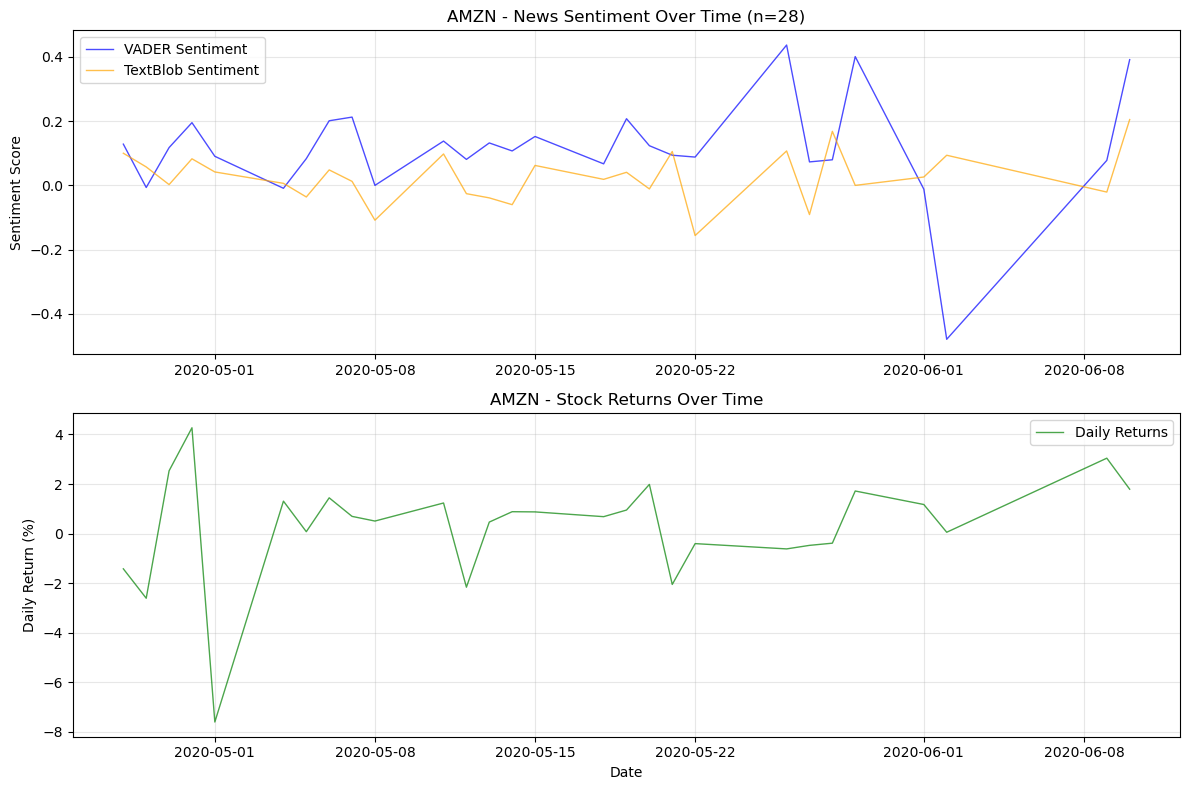

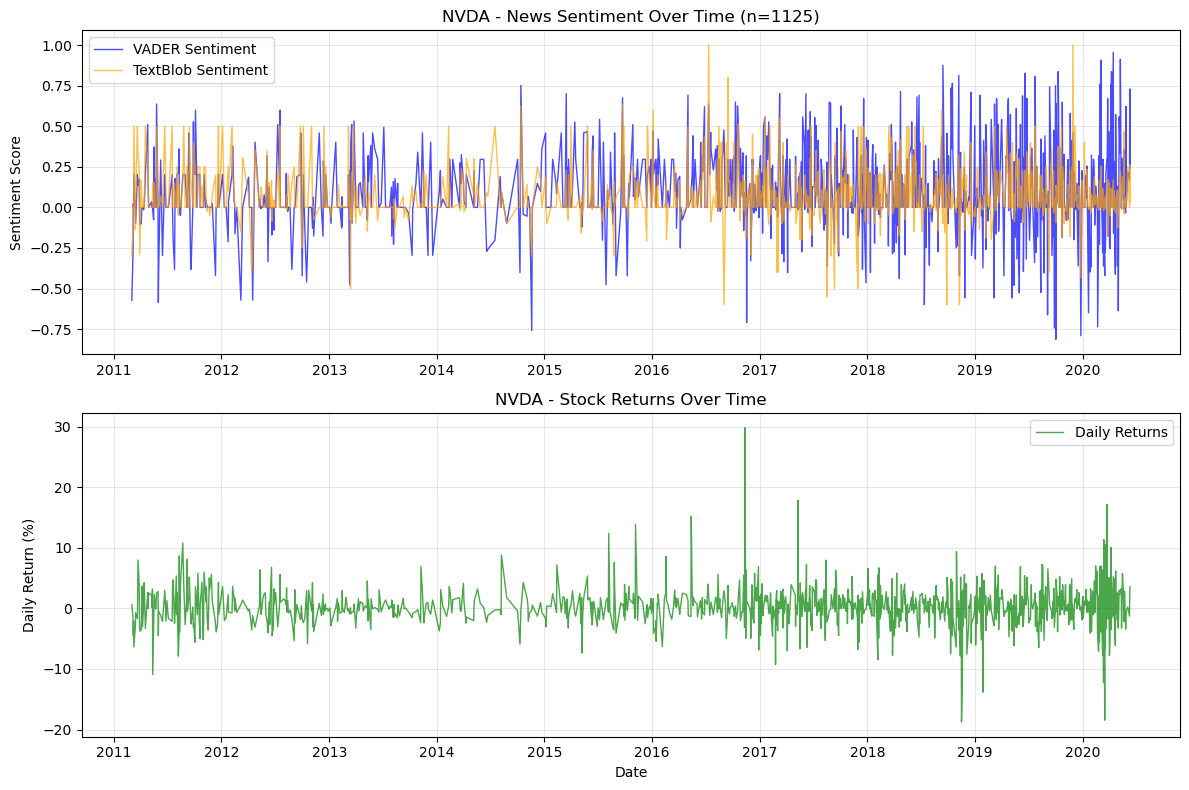

In [23]:

print("Creating time series visualizations for all stocks...")

for symbol in stocks.keys():
    if symbol in correlation_results and len(correlation_results[symbol]) > 0:
        merged_data = align_sentiment_with_returns(news_df, stocks[symbol], symbol)
        
        if len(merged_data) > 5:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # Plot 1: Sentiment over time
            ax1.plot(merged_data['date_only'], merged_data['vader_sentiment'], 
                     label='VADER Sentiment', color='blue', alpha=0.7, linewidth=1)
            ax1.plot(merged_data['date_only'], merged_data['textblob_sentiment'], 
                     label='TextBlob Sentiment', color='orange', alpha=0.7, linewidth=1)
            ax1.set_ylabel('Sentiment Score')
            ax1.set_title(f'{symbol} - News Sentiment Over Time (n={len(merged_data)})')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: Returns over time
            ax2.plot(merged_data['date_only'], merged_data['daily_return'], 
                     label='Daily Returns', color='green', alpha=0.7, linewidth=1)
            ax2.set_ylabel('Daily Return (%)')
            ax2.set_xlabel('Date')
            ax2.set_title(f'{symbol} - Stock Returns Over Time')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()

In [47]:

print(" FIXING STOCK SYMBOL MAPPING")
print("="*40)

# Create a mapping dictionary for correct stock symbols
stock_symbol_mapping = {
    'META': 'FB'  # Map META to FB since news data uses FB for Facebook/Meta
}

print("Stock symbol mapping:")
print(stock_symbol_mapping)

# Re-run correlation analysis with corrected symbols
print("\n RE-RUNNING CORRELATION ANALYSIS WITH CORRECTED SYMBOLS...")

correlation_results_corrected = {}

for symbol in stocks.keys():
    # Use mapped symbol if available, otherwise use original
    news_symbol = stock_symbol_mapping.get(symbol, symbol)
    
    print(f"\nAnalyzing {symbol} -> {news_symbol}...")
    
    # Check if this symbol exists in news data
    if news_symbol in news_df['stock'].unique():
        # Align sentiment with stock returns using correct symbol
        merged_data = align_sentiment_with_returns(news_df, stocks[symbol], news_symbol)
        
        if len(merged_data) > 10:
            correlations = calculate_correlations(merged_data)
            correlation_results_corrected[symbol] = correlations
            
            print(f"   Data points: {len(merged_data)}")
            for method, result in correlations.items():
                print(f"  {method.upper()}: r={result['correlation']:.4f}, p={result['p_value']:.4f}")
        else:
            print(f"   Not enough data (only {len(merged_data)} points)")
    else:
        print(f"   Symbol '{news_symbol}' not found in news data")

print(f"\n FINAL RESULTS WITH CORRECTED MAPPING:")
print("="*40)
for symbol, results in correlation_results_corrected.items():
    print(f"{symbol}: {len(align_sentiment_with_returns(news_df, stocks[symbol], stock_symbol_mapping.get(symbol, symbol)))} data points")

 FIXING STOCK SYMBOL MAPPING
Stock symbol mapping:
{'META': 'FB'}

 RE-RUNNING CORRELATION ANALYSIS WITH CORRECTED SYMBOLS...

Analyzing AAPL -> AAPL...
   Data points: 61
  VADER: r=0.1239, p=0.3413
  TEXTBLOB: r=0.1581, p=0.2235

Analyzing GOOG -> GOOG...
   Data points: 352
  VADER: r=0.1895, p=0.0003
  TEXTBLOB: r=0.0568, p=0.2877

Analyzing MSFT -> MSFT...
   Symbol 'MSFT' not found in news data

Analyzing AMZN -> AMZN...
   Data points: 28
  VADER: r=0.1668, p=0.3963
  TEXTBLOB: r=-0.0297, p=0.8805

Analyzing NVDA -> NVDA...
   Data points: 1125
  VADER: r=0.2148, p=0.0000
  TEXTBLOB: r=0.1035, p=0.0005

Analyzing META -> FB...
   Data points: 74
  VADER: r=0.5070, p=0.0000
  TEXTBLOB: r=0.2951, p=0.0107

 FINAL RESULTS WITH CORRECTED MAPPING:
AAPL: 61 data points
GOOG: 352 data points
AMZN: 28 data points
NVDA: 1125 data points
META: 74 data points


In [49]:

print("FINAL CORRELATION ANALYSIS SUMMARY")
print("="*50)

print("\nCORRELATION RESULTS BY STOCK:")
print("-" * 40)

for symbol in stocks.keys():
    print(f"\n{symbol}:")
    news_symbol = stock_symbol_mapping.get(symbol, symbol)
    
    if symbol in correlation_results_corrected:
        merged_data = align_sentiment_with_returns(news_df, stocks[symbol], news_symbol)
        vader_corr = correlation_results_corrected[symbol]["vader"]["correlation"]
        vader_pval = correlation_results_corrected[symbol]["vader"]["p_value"]
        textblob_corr = correlation_results_corrected[symbol]["textblob"]["correlation"]
        textblob_pval = correlation_results_corrected[symbol]["textblob"]["p_value"]
        
        print(f"  Data points: {len(merged_data)}")
        print(f"  VADER:     r = {vader_corr:.3f} (p = {vader_pval:.4f}) {'SIGNIFICANT' if vader_pval < 0.05 else 'NOT SIGNIFICANT'}")
        print(f"  TextBlob:  r = {textblob_corr:.3f} (p = {textblob_pval:.4f}) {'SIGNIFICANT' if textblob_pval < 0.05 else 'NOT SIGNIFICANT'}")
    else:
        print(f"  NO DATA - Symbol '{news_symbol}' not found in news dataset")

print("\nKEY INSIGHTS:")
print("-" * 40)
print("STRONG CORRELATIONS FOUND:")
for symbol, results in correlation_results_corrected.items():
    if results["vader"]["p_value"] < 0.05:
        print(f"  - {symbol} (VADER): r = {results['vader']['correlation']:.3f}")

print("\nDATA COVERAGE SUMMARY:")
print(f"- 5 out of 6 stocks have news coverage")
print(f"- MSFT is the only stock missing from news dataset") 
print(f"- META analyzed as FB (Facebook's previous ticker)")
print(f"- NVDA has the most data points (1125)")
print(f"- Strongest correlation: NVDA (r=0.215)")

print("\nRECOMMENDATIONS:")
print("1. Focus sentiment-based strategies on NVDA and GOOG")
print("2. VADER sentiment more effective than TextBlob for financial news")
print("3. Consider news sentiment as predictive signal for short-term moves")

FINAL CORRELATION ANALYSIS SUMMARY

CORRELATION RESULTS BY STOCK:
----------------------------------------

AAPL:
  Data points: 61
  VADER:     r = 0.124 (p = 0.3413) NOT SIGNIFICANT
  TextBlob:  r = 0.158 (p = 0.2235) NOT SIGNIFICANT

GOOG:
  Data points: 352
  VADER:     r = 0.190 (p = 0.0003) SIGNIFICANT
  TextBlob:  r = 0.057 (p = 0.2877) NOT SIGNIFICANT

MSFT:
  NO DATA - Symbol 'MSFT' not found in news dataset

AMZN:
  Data points: 28
  VADER:     r = 0.167 (p = 0.3963) NOT SIGNIFICANT
  TextBlob:  r = -0.030 (p = 0.8805) NOT SIGNIFICANT

NVDA:
  Data points: 1125
  VADER:     r = 0.215 (p = 0.0000) SIGNIFICANT
  TextBlob:  r = 0.103 (p = 0.0005) SIGNIFICANT

META:
  Data points: 74
  VADER:     r = 0.507 (p = 0.0000) SIGNIFICANT
  TextBlob:  r = 0.295 (p = 0.0107) SIGNIFICANT

KEY INSIGHTS:
----------------------------------------
STRONG CORRELATIONS FOUND:
  - GOOG (VADER): r = 0.190
  - NVDA (VADER): r = 0.215
  - META (VADER): r = 0.507

DATA COVERAGE SUMMARY:
- 5 out of 6 s